# Detectarea Fraudelor pentru Bonuri Fiscale

### Biblioteci Folosite

In [82]:
# decomentare daca nu sunt instalate deja

# %pip install matplotlib
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install nltk
# %pip install scikit-learn
# %pip install seaborn

### Citire Date

In [83]:
import pandas as pd

df = pd.read_csv("bonuri_fiscale.csv")

### EDA (Exploratory Data Analysis)

1. Histogramă după sume
2. Bonuri suspecte după oră
3. Corelații între număr de produse și sumă

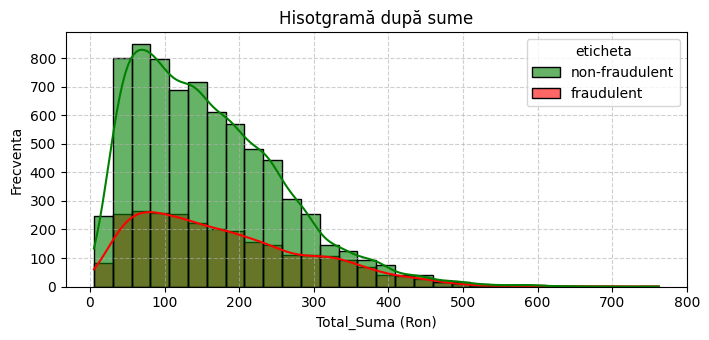

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7.2, 3.5))
sns.histplot(data=df, x="Total_suma", hue="eticheta", bins=30, kde=True, palette=["green", "red"], alpha=0.6)
plt.title("Hisotgramă după sume")
plt.xlabel('Total_Suma (Ron)')
plt.ylabel('Frecventa')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [85]:
# functie pentru a converti ora din sir de caractere in minute din zi
def ora_in_minute(ora_str):
    h, m, s = map(int, ora_str.split(":"))
    return h * 60 + m + s / 60

if "minute_emitere" not in df.columns:
    df["minute_emitere"] = df["Oră_emitere"].apply(ora_in_minute)

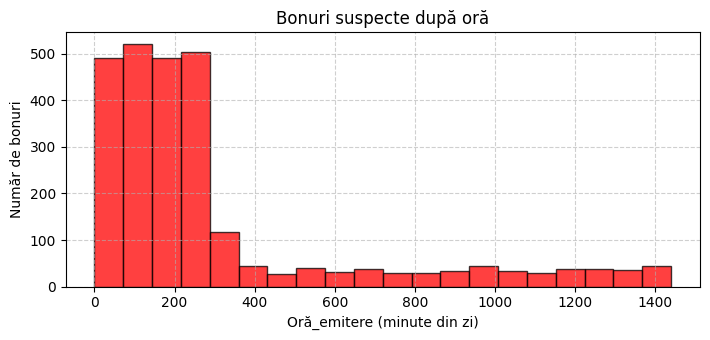

In [86]:
df_fraud = df[df["eticheta"] == "fraudulent"]

plt.figure(figsize=(7.2, 3.5))
plt.hist(df_fraud["minute_emitere"], bins=20, color='red', edgecolor='black', alpha=0.75)
plt.title("Bonuri suspecte după oră")
plt.xlabel('Oră_emitere (minute din zi)')
plt.ylabel('Număr de bonuri')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [87]:
correlatie = df["Număr_produse"].corr(df["Total_suma"])
print(f"Coeficientul de corelatie: {correlatie:.3f}")

Coeficientul de corelatie: 0.583


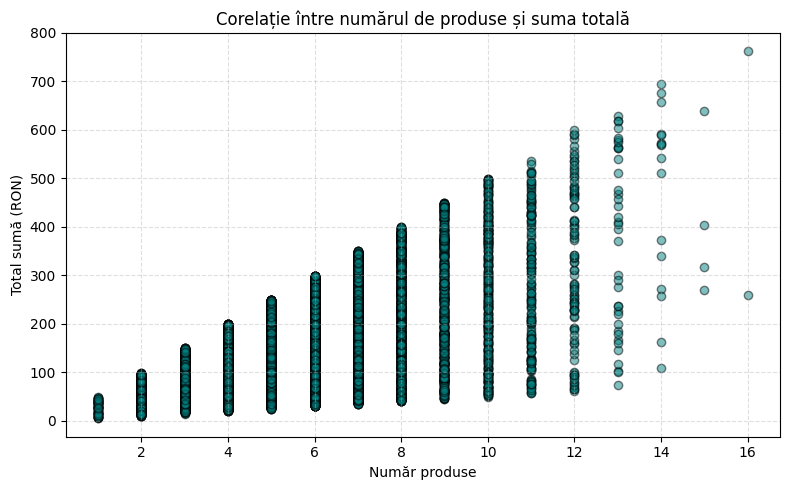

In [88]:
plt.figure(figsize=(8, 5))
plt.scatter(df["Număr_produse"], df["Total_suma"], alpha=0.5, color="teal", edgecolors='k')
plt.title("Corelație între numărul de produse și suma totală")
plt.xlabel("Număr produse")
plt.ylabel("Total sumă (RON)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [89]:
# convertire eticheta in valori binare
df["eticheta"] = df["eticheta"].map({"non-fraudulent": 0, "fraudulent": 1})

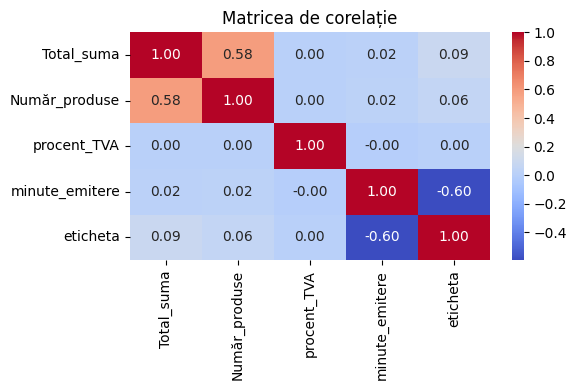

In [90]:
corelatii = df[["Total_suma", "Număr_produse", "procent_TVA", "minute_emitere", "eticheta"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corelatii, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matricea de corelație")
plt.tight_layout()
plt.show()

### Împărțirea setului de date

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
# drop coloane redundante
df = df.drop(columns=["Oră_emitere", "motiv_frauda"])

# codificare one_hot
df = pd.get_dummies(df, columns=["metoda_plata", "Comerciant_id"], drop_first=True)

# impartire in features (X) si target (Y)
X = df.drop(columns=["eticheta"])
Y = df["eticheta"]

# impartirea setului de date in train si test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(Y_train.value_counts())

eticheta
0    5874
1    2126
Name: count, dtype: int64


### Antrenarea Modelului

In [96]:
# scalarea datelor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
model = LogisticRegression(
    class_weight='balanced',
    max_iter=3000,
    solver='lbfgs',
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1469
           1       0.75      0.93      0.83       531

    accuracy                           0.90      2000
   macro avg       0.86      0.91      0.88      2000
weighted avg       0.91      0.90      0.90      2000



In [104]:
model_nelin = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model_nelin.fit(X_train, Y_train)

Y_pred_rf = model_nelin.predict(X_test)

print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1469
           1       1.00      0.89      0.94       531

    accuracy                           0.97      2000
   macro avg       0.98      0.94      0.96      2000
weighted avg       0.97      0.97      0.97      2000

